In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import auc,roc_curve
from sklearn.ensemble import RandomForestClassifier,RandomTreesEmbedding
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("../data/scale_train.csv",nrows=5000)
train.drop('Unnamed: 0',inplace= True,axis=1)

In [3]:
def kf_with_model(data,model):
    kf = KFold(5)
    res = pd.DataFrame()

    for train_index,test_index in kf.split(data):
        model_train = data.iloc[train_index]
        model_test = data.iloc[test_index]

        train_y = model_train['target']
        train_x = model_train.drop('target',axis = 1)

        test_y = model_test['target']
        test_x = model_test.drop('target', axis = 1)

        model.fit(train_x,train_y)

        pred_label = model.predict(test_x)
        pred_prob = model.predict_proba(test_x)

        preds = pd.DataFrame()
        preds['label'] = test_y
        preds['pred'] = pred_label
        preds['prob'] = pred_prob[:,1]
        res = res.append(preds)
    return(res)

In [4]:
def plotGraph(df):
    predicts_list = df.columns[1:]
    aucs = pd.DataFrame(columns=['models','auc_score'])
    y = df['label']
    for res in predicts_list:
        fpr,tpr,thres = roc_curve(y,df[res])
        auc_score = auc(fpr,tpr)
        aucs = aucs.append({'models':res,'auc_score':auc_score},ignore_index=True)
        
        plt.plot(fpr,tpr,lw=1, alpha=0.3,label = res+' : '+str(round(auc_score,3)))
    
    plt.legend(loc='lower right')
    plt.show()
    return(aucs)

In [6]:
base_line_res = kf_with_model(train,LogisticRegression(C=0.01))
balance_line_res = kf_with_model(train,LogisticRegression(C=0.01,class_weight = 'balanced'))
base_svc_res = kf_with_model(train,SVC(probability=True))
balance_svc_res = kf_with_model(train,SVC(C=0.01,class_weight='balanced',probability=True))

#rf_base_res = kf_with_model(train,RandomForestClassifier(max_depth=5))

In [7]:
result_df = pd.DataFrame()
result_df['label'] = train['target']

In [8]:
result_df['base_prob'] = base_line_res['prob']
result_df['balance_prob'] = balance_line_res['prob']
result_df['svc_prob'] = base_svc_res['prob']
result_df['ba_svc_prob'] = balance_svc_res['prob']

#result_df['rf_base_prob'] = rf_base_res['prob']


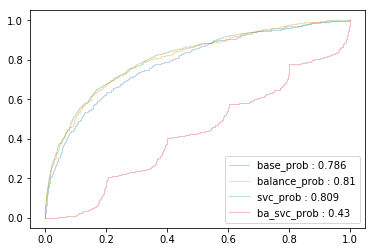

,models,auc_score
0,base_prob,0.786017
1,balance_prob,0.809742
2,svc_prob,0.809224
3,ba_svc_prob,0.430304


In [9]:
plotGraph(result_df)